In [1]:
root = "/work/Master_Project/Snakemake"
import sys
sys.path.append("/work/Master_Project/Snakemake") 
sys.path.append("/work/Master_Project/Snakemake/benchmark_analysis")
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import scanpy as sc
from matplotlib.ticker import MaxNLocator
import yaml
from parse_config import *
from  matplotlib.ticker import FuncFormatter
import scanpy as sc
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import defaultdict
from critdd import Diagram
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp



plt.rcParams['text.usetex'] = False


configfile = "/work/Master_Project/Snakemake/config.yaml"

with open(configfile, "r") as f:
    config = yaml.safe_load(f)  # Load YAML config into a dictionary

cfg = PrepConfig(config)  # Now use PrepConfig


In [2]:
def match_rows_fast(df1_row, df2, columns_to_match):
    conditions = [
        df2[col].values == (str(df1_row[col]) if df2[col].dtype == 'object' else df1_row[col])
        for col in columns_to_match
    ]
    mask = np.logical_and.reduce(conditions)
    return df2[mask]

In [50]:
def critical_difference(results, algorithm, evaluation_measure, scenario,output_dir ='/work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/'):
    subset_algorithm = results[results['Clustering_algorithm'] == algorithm]
    if scenario == 'mean':
        grouped =  subset_algorithm.groupby(['Quality_Function','Graph_type','Dataset'], as_index= False)[evaluation_measure].mean()
    else:
        grouped =  subset_algorithm.groupby(['Quality_Function','Graph_type','Dataset'], as_index= False)[evaluation_measure].max()
    grouped['Configuration'] = grouped['Quality_Function'] + '_' + grouped['Graph_type']
    pivoted = grouped.pivot(index='Dataset', columns='Configuration', values=evaluation_measure)
    clean_data = pivoted.dropna(axis=0)
    def adjust_colname(colname):
        if '_' in colname:
            parts = colname.split('_', 1)
            return parts[0] + '_' + parts[1].capitalize()
        return colname

    clean_data.columns = [adjust_colname(col) for col in clean_data.columns]
    stats, p_value = friedmanchisquare(*[clean_data[col] for col in clean_data.columns])
    nemenyi_results = sp.posthoc_nemenyi_friedman(clean_data)
    ranks = clean_data.rank(axis=1, ascending=False)
    avg_ranks = ranks.mean()
    plt.figure(figsize=(10, 4))
    sp.critical_difference_diagram(avg_ranks,nemenyi_results)
    # Make algorithm and evaluation_measure title-cased for the title
    algorithm_title = algorithm.title()
    evaluation_measure_title = evaluation_measure.upper()  # Usually, evaluation measures are uppercase
    plt.title(f"Critical Difference Diagram for {algorithm_title} Algorithm ({evaluation_measure_title})", fontsize=12)
        # Create output file names
    base_filename = f"CD_{algorithm}_{evaluation_measure}_{scenario}"
    png_filename = os.path.join(output_dir, f"{base_filename}.png")
    eps_filename = os.path.join(output_dir, f"{base_filename}.eps")
    
    # Save plots
    plt.savefig(png_filename, format='png', bbox_inches='tight')
    plt.savefig(eps_filename, format='eps', bbox_inches='tight')
    
    print(f"Saved: {png_filename}")
    print(f"Saved: {eps_filename}")
    
    plt.close()
    return stats, p_value
    

NameError: name 'critical_difference_subplot' is not defined

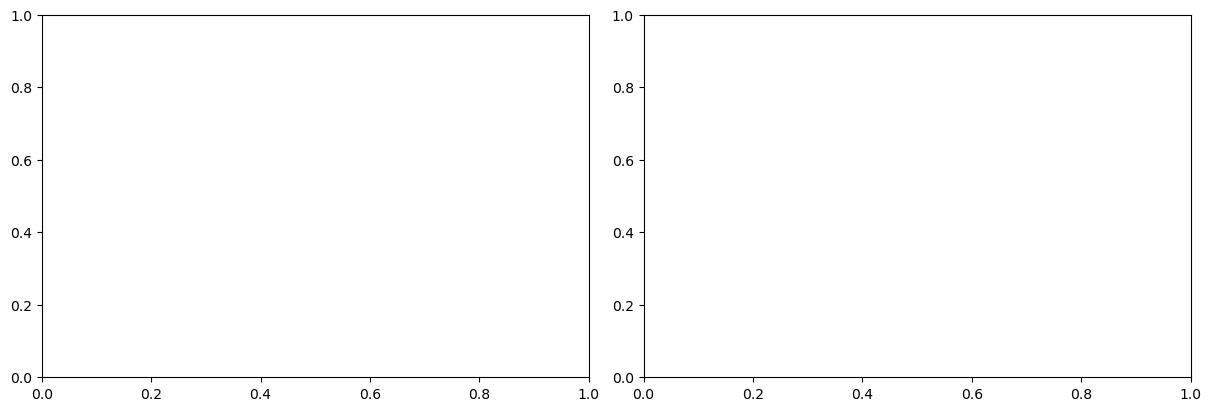

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # Plot for algorithm 1
stats1, pval1 = critical_difference_subplot(axs[0], results, algorithm1, evaluation_measure, scenario)
axs[0].set_title(f"(a) {algorithm1.title()}", fontsize=12)

    # Plot for algorithm 2
stats2, pval2 = critical_difference_subplot(axs[1], results, algorithm2, evaluation_measure, scenario)
axs[1].set_title(f"(b) {algorithm2.title()}", fontsize=12)

    # Save
base_filename = f"CD_{evaluation_measure}_{scenario}_{algorithm1}_{algorithm2}"
png_filename = os.path.join(output_dir, f"{base_filename}.png")
eps_filename = os.path.join(output_dir, f"{base_filename}.eps")
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.savefig(eps_filename, format='eps', dpi=300, bbox_inches='tight')

print(f"Saved: {png_filename}")
print(f"Saved: {eps_filename}")
plt.close()

return (stats1, pval1), (stats2, pval2)

In [55]:
import matplotlib.pyplot as plt
import os

def critical_difference_subplot(ax, results, algorithm, evaluation_measure, scenario):
    subset_algorithm = results[results['Clustering_algorithm'] == algorithm]

    if scenario == 'mean':
        grouped = subset_algorithm.groupby(['Quality_Function', 'Graph_type', 'Dataset'], as_index=False)[evaluation_measure].mean()
    else:
        grouped = subset_algorithm.groupby(['Quality_Function', 'Graph_type', 'Dataset'], as_index=False)[evaluation_measure].max()

    grouped['Configuration'] = grouped['Quality_Function'] + '_' + grouped['Graph_type']
    pivoted = grouped.pivot(index='Dataset', columns='Configuration', values=evaluation_measure)
    clean_data = pivoted.dropna(axis=0)

    def adjust_colname(colname):
        if '_' in colname:
            parts = colname.split('_', 1)
            return parts[0] + '_' + parts[1].capitalize()
        return colname

    clean_data.columns = [adjust_colname(col) for col in clean_data.columns]

    # Friedman & posthoc
    from scipy.stats import friedmanchisquare
    stats, p_value = friedmanchisquare(*[clean_data[col] for col in clean_data.columns])
    nemenyi_results = sp.posthoc_nemenyi_friedman(clean_data)

    # Ranks
    ranks = clean_data.rank(axis=1, ascending=False)
    avg_ranks = ranks.mean()

    # Plot
    sp.critical_difference_diagram(avg_ranks, nemenyi_results, ax=ax)
    algorithm_title = algorithm.title()
    evaluation_measure_title = evaluation_measure.upper()
    ax.set_title(f"({algorithm_title}) {evaluation_measure_title}", fontsize=11, weight='bold')
    ax.set_xlabel("")  # Remove x-label

    return stats, p_value

def plot_two_algorithms(results, algorithm1, algorithm2, evaluation_measure, scenario, output_dir):
    fig, axs = plt.subplots(2, 1, figsize=(12, 4), constrained_layout=True)

    # Plot for algorithm 1
    stats1, pval1 = critical_difference_subplot(axs[0], results, algorithm1, evaluation_measure, scenario)
    axs[0].set_title(f"(a) {algorithm1.title()}", fontsize=12)

    # Plot for algorithm 2
    stats2, pval2 = critical_difference_subplot(axs[1], results, algorithm2, evaluation_measure, scenario)
    axs[1].set_title(f"(b) {algorithm2.title()}", fontsize=12)

    # Save
    base_filename = f"CD_{evaluation_measure}_{scenario}_{algorithm1}_{algorithm2}"
    png_filename = os.path.join(output_dir, f"{base_filename}.png")
    eps_filename = os.path.join(output_dir, f"{base_filename}.eps")
    plt.savefig(png_filename, dpi=300, bbox_inches='tight')
    plt.savefig(eps_filename, format='eps', dpi=300, bbox_inches='tight')

    print(f"Saved: {png_filename}")
    print(f"Saved: {eps_filename}")
    plt.close()

    return (stats1, pval1), (stats2, pval2)

In [58]:
# Example usage
algorithms = ['leiden', 'louvain']
evaluation_measure = 'NMI'  # or any measure you want
scenario = 'mean'  # or 'max'
output_dir = '/work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/'

plot_two_algorithms(df_matches_best_k_res, algorithms[0], algorithms[1], evaluation_measure, scenario, output_dir)

Saved: /work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/CD_NMI_mean_leiden_louvain.png
Saved: /work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/CD_NMI_mean_leiden_louvain.eps


((117.85924194356316, 4.883141367852344e-20),
 (129.9094856379426, 1.815807658333543e-22))

## Load all results

In [21]:
all_results = pd.read_pickle("/work/Master_Project/Notebooks/results_dataframes/benchmark_all_results.pkl")

In [5]:
best_comb = pd.read_pickle("best_combinations_processed_PCA.pkl")

In [22]:
for idx,row in best_comb.iterrows():
    best_comb.loc[idx,'Standard'] = cfg.get_from_dataset(row[0], 'standard')

/tmp/ipykernel_1301/3771923722.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_comb.loc[idx,'Standard'] = cfg.get_from_dataset(row[0], 'standard')


In [23]:
best_comb_expanded = best_comb.assign(
    Similarity_Measure=best_comb['Similarity_Measure'].str.split('/')
).explode('Similarity_Measure')

#best_comb_expanded.replace("Phs", "Phi", inplace=True)
#best_comb_expanded.replace("rho", "Rho", inplace=True)
#best_comb_expanded.replace("pearson", "Pearson", inplace=True)


In [24]:
best_comb_shrink = best_comb_expanded.groupby(['Dataset', 'Clustering_algorithm']).first().reset_index()

In [25]:
algorithms = ['leiden', 'louvain']
measures = ['PSI', 'NMI', 'ARI', 'PCA_score']

In [27]:
matches_best_k_res= []
for idx, row in best_comb_shrink.sort_values(by=['Standard','Dataset']).iterrows():
    matches = match_rows_fast(row, all_results, ['Dataset','K_Neighbors', 'Clustering_algorithm','Resolution']).copy()
    matches['standard'] = row.Standard    
    matches_best_k_res.append(matches)

In [29]:
df_matches_best_k_res = pd.concat(matches_best_k_res)

In [32]:
df_matches_best_k_res.groupby(['Quality_Function','Graph_type','Dataset'], as_index= False)['ARI'].mean()

,Quality_Function,Graph_type,Dataset,ARI
0,CPMVertexPartition,gauss,BaronPancreasData,0.053017
1,CPMVertexPartition,gauss,Biase,0.372456
2,CPMVertexPartition,gauss,DarmanisBrainData,0.023033
3,CPMVertexPartition,gauss,Deng,0.110300
4,CPMVertexPartition,gauss,Goolam,0.522709
...,...,...,...,...
256,RBERVertexPartition,umap,Tian-sce_sc_Dropseq_qc,0.888030
257,RBERVertexPartition,umap,XinPancreasData,0.475958
258,RBERVertexPartition,umap,Yan,0.744607
259,RBERVertexPartition,umap,ZeiselBrainData,0.430540


# Statistical testing for differences between algorithms

## Wilcoxon signed rank test

In [11]:
from scipy.stats import wilcoxon

In [12]:
def compare_algorithms(data, metric, scenario):
    if scenario == 'mean' :
        mean_group = all_results.groupby(['Dataset','Clustering_algorithm'])[metric].mean().reset_index()
        result = wilcoxon(mean_group.loc[mean_group['Clustering_algorithm']=='leiden'][metric],mean_group.loc[mean_group['Clustering_algorithm']=='louvain'][metric])
    else:
        max_group = all_results.groupby(['Dataset','Clustering_algorithm'])[metric].max().reset_index()
        result = wilcoxon(max_group.loc[max_group['Clustering_algorithm']=='leiden'][metric],max_group.loc[max_group['Clustering_algorithm']=='louvain'][metric])
    return result    

In [13]:
for measure in measures:
    res = compare_algorithms(all_results, measure, 'max')
    print(measure)
    print(res)

/work/Master_Project/miniconda3/envs/sc_benchmark/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


PSI
WilcoxonResult(statistic=27.0, pvalue=0.5937116848746409)


/work/Master_Project/miniconda3/envs/sc_benchmark/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/work/Master_Project/miniconda3/envs/sc_benchmark/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


NMI
WilcoxonResult(statistic=8.0, pvalue=0.6001794871405538)


/work/Master_Project/miniconda3/envs/sc_benchmark/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/work/Master_Project/miniconda3/envs/sc_benchmark/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


ARI
WilcoxonResult(statistic=7.0, pvalue=0.23672357063785732)
PCA_score
WilcoxonResult(statistic=22.0, pvalue=0.9527650219907529)


/work/Master_Project/miniconda3/envs/sc_benchmark/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/work/Master_Project/miniconda3/envs/sc_benchmark/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [14]:
for measure in measures:
    res = compare_algorithms(all_results, measure, 'mean')
    print(measure)
    print(res)

PSI
WilcoxonResult(statistic=86.0, pvalue=0.19821882247924805)
NMI
WilcoxonResult(statistic=77.0, pvalue=0.11287164688110352)
ARI
WilcoxonResult(statistic=21.0, pvalue=0.00021314620971679688)
PCA_score
WilcoxonResult(statistic=62.0, pvalue=0.03587532043457031)


# Statistical testing for combinations of graph type and quality function

## Critical difference plots for adjusted k and resolution, aggregation for different distance measures (in paper)

First find and only leave rows with resolution and k found according to the best combination.

In [39]:
matches_best_k_res= []
for idx, row in best_comb_shrink.sort_values(by=['Standard','Dataset']).iterrows():
    matches = match_rows_fast(row, all_results, ['Dataset','K_Neighbors', 'Clustering_algorithm','Resolution']).copy()
    matches['standard'] = row.Standard    
    matches_best_k_res.append(matches)

In [40]:
df_matches_best_k_res= pd.concat(matches_best_k_res)

In [42]:
df_matches_best_k_res.groupby(['Quality_Function','Graph_type','Dataset'], as_index= False)['ARI'].mean()

,Quality_Function,Graph_type,Dataset,ARI
0,CPMVertexPartition,gauss,BaronPancreasData,0.053017
1,CPMVertexPartition,gauss,Biase,0.372456
2,CPMVertexPartition,gauss,DarmanisBrainData,0.023033
3,CPMVertexPartition,gauss,Deng,0.110300
4,CPMVertexPartition,gauss,Goolam,0.522709
...,...,...,...,...
256,RBERVertexPartition,umap,Tian-sce_sc_Dropseq_qc,0.888030
257,RBERVertexPartition,umap,XinPancreasData,0.475958
258,RBERVertexPartition,umap,Yan,0.744607
259,RBERVertexPartition,umap,ZeiselBrainData,0.430540


In [51]:
for algorithm in algorithms:
    for measure in measures:
        stats, pval = critical_difference(df_matches_best_k_res, algorithm, measure, 'mean')
        print(stats,pval)

Saved: /work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/CD_leiden_PSI_mean.png
Saved: /work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/CD_leiden_PSI_mean.eps
129.5626982801803 2.134191666986488e-22
Saved: /work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/CD_leiden_NMI_mean.png
Saved: /work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/CD_leiden_NMI_mean.eps
117.85924194356316 4.883141367852344e-20
Saved: /work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/CD_leiden_ARI_mean.png
Saved: /work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/CD_leiden_ARI_mean.eps
134.61362497912842 2.0230412996794176e-23
Saved: /work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/CD_leiden_PCA_score_mean.png
Saved: /work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/CD_leiden_PCA_score_mean.eps
150.00884955752215 1.4842780932640285e-26
Saved: /work/Master_Project/Notebooks/plots_paper/Friedman-Nemyeni/CD_louvain_PSI_mean.png
Saved: /work

## Critical difference for the best score for a particular combination of graph type and quality function (for a given evaluation measure)

This will result in different best similarity measures per dataset

KeyError: "None of [Index(['RBERVertexPartition_Umap', 'RBERVertexPartition_Jaccard_seurat',\n       'CPMVertexPartition_Gauss',\n       'RBConfigurationVertexPartition_Jaccard_seurat',\n       'CPMVertexPartition_Jaccard_seurat',\n       'CPMVertexPartition_Jaccard_phenograph',\n       'RBConfigurationVertexPartition_Gauss', 'RBERVertexPartition_Gauss',\n       'RBConfigurationVertexPartition_Jaccard_phenograph',\n       'RBConfigurationVertexPartition_Umap',\n       'RBERVertexPartition_Jaccard_phenograph'],\n      dtype='object', name='Configuration')] are in the [index]"

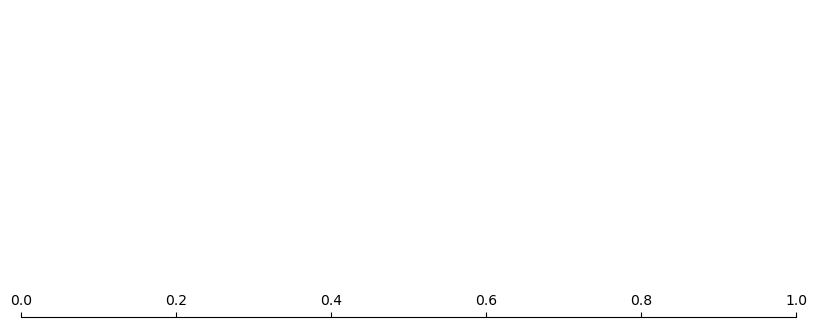

In [48]:
for algorithm in algorithms:
    for measure in measures:
        stats, pval = critical_difference(all_results, algorithm, measure, scenario='max')
        print(stats,pval)

## Critical difference for the mean score for a particular combination of graph type and quality function (for a given evaluation measure) - aggregated across all resolution, all k and all distance measures

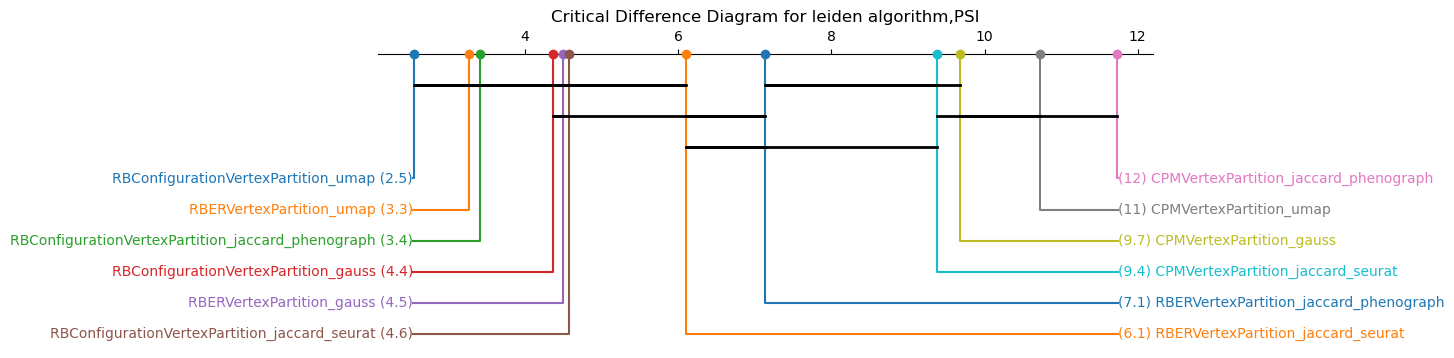

185.45421245421244 7.657064411458615e-34


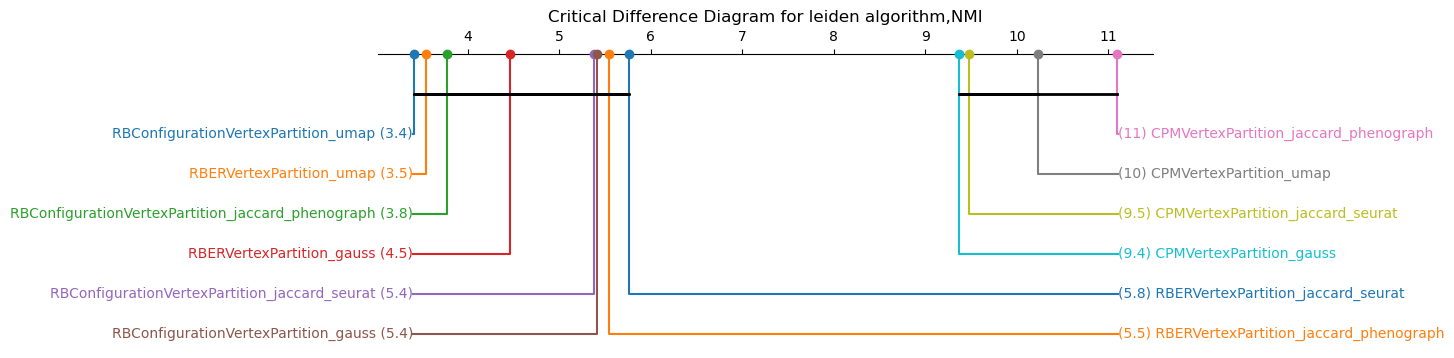

141.71794871794873 7.283225622094449e-25


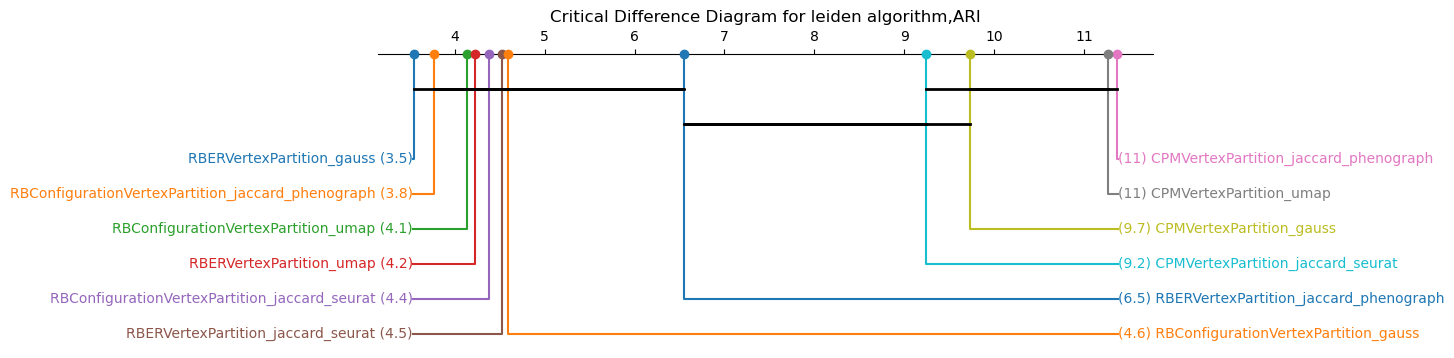

170.69963369963375 8.46900901942656e-31


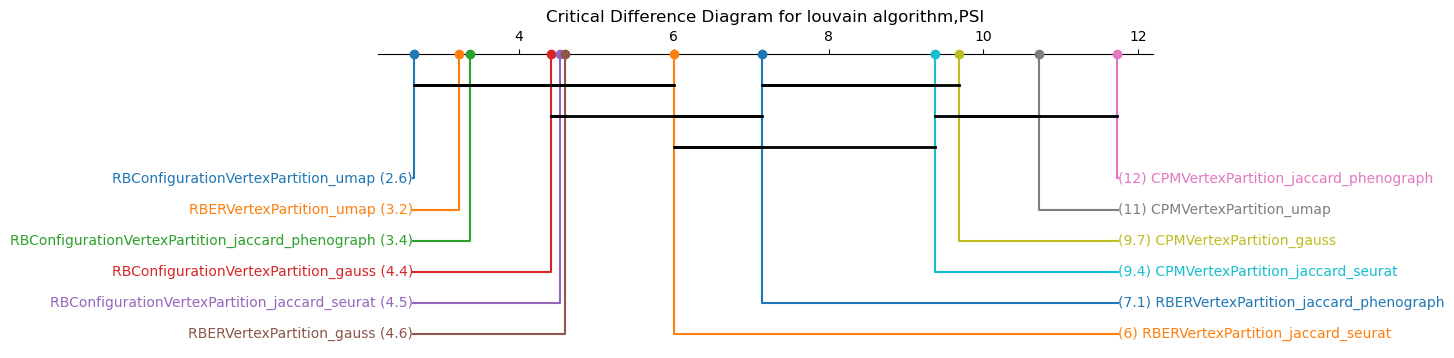

184.77289377289378 1.0589990922681434e-33


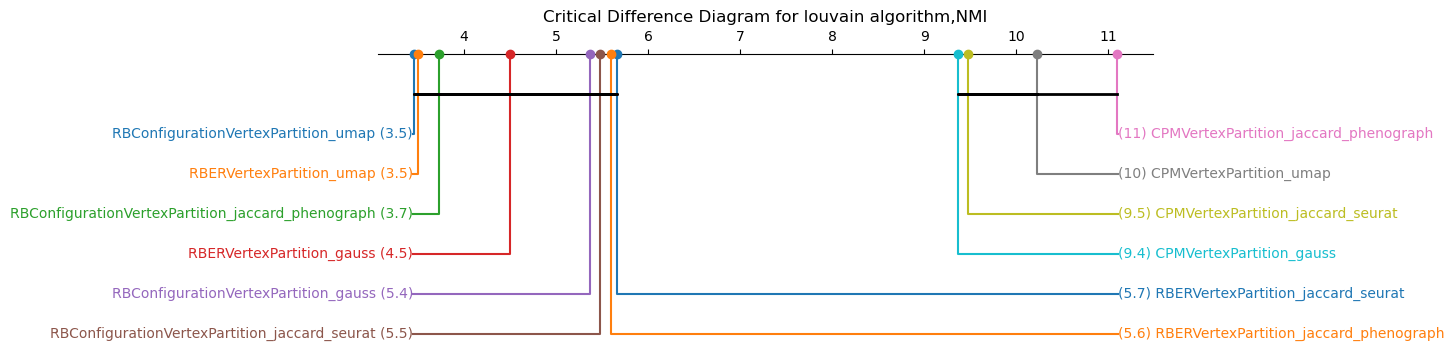

141.7545787545788 7.159247022470768e-25


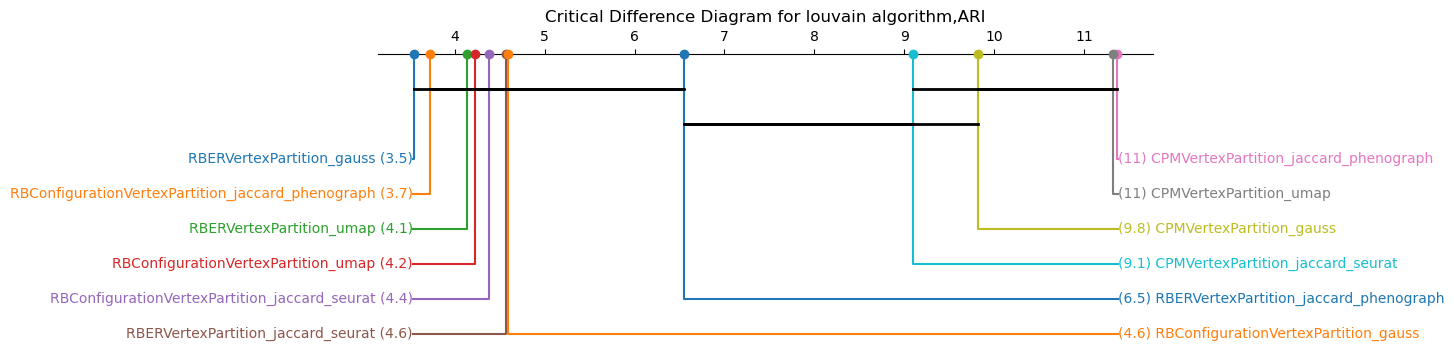

171.24175824175825 6.5498906161496695e-31


In [28]:
for algorithm in algorithms:
    for measure in measures:
        stats, pval = critical_difference(all_results, algorithm, measure, scenario='mean')
        print(stats,pval)

#### Scenario with the best values for each of these per dataset

In [9]:
all_results = pd.read_pickle("/work/Master_Project/Notebooks/benchmark_all_results.pkl")

In [54]:
grouped_leiden =  all_results[all_results['Clustering_algorithm']=='leiden'].groupby(['Quality_Function','Graph_type','Dataset'], as_index= False)['ARI'].max()
grouped_louvain =  all_results[all_results['Clustering_algorithm']=='louvain'].groupby(['Quality_Function','Graph_type','Dataset'], as_index= False)['ARI'].max()

In [72]:
grouped_louvain['Configuration'] = grouped_louvain['Quality_Function'] + '_' + grouped_louvain['Graph_type']
pivoted_louv = grouped_louvain.pivot(index='Dataset', columns=['Configuration'], values='ARI').iloc[:-1,:]

In [74]:
grouped_leiden['Configuration'] = grouped_leiden['Quality_Function'] + '_' + grouped_leiden['Graph_type']
pivoted_leid = leid_subset.pivot(index='Dataset', columns=['Configuration'], values='ARI').iloc[:-1,:]

In [75]:
nemenyi_results_louv = sp.posthoc_nemenyi_friedman(pivoted_louv)

In [76]:
nemenyi_results_leid = sp.posthoc_nemenyi_friedman(pivoted_leid)

In [77]:
nemenyi_results_leid

,CPMVertexPartition_gauss,CPMVertexPartition_jaccard_phenograph,CPMVertexPartition_jaccard_seurat,CPMVertexPartition_umap,RBConfigurationVertexPartition_gauss,RBConfigurationVertexPartition_jaccard_phenograph,RBConfigurationVertexPartition_jaccard_seurat,RBConfigurationVertexPartition_umap,RBERVertexPartition_gauss,RBERVertexPartition_jaccard_phenograph,RBERVertexPartition_jaccard_seurat,RBERVertexPartition_umap
CPMVertexPartition_gauss,1.000000,0.981246,0.999746,0.546636,1.000000,1.000000,1.000000,0.983573,0.992026,1.000000,1.000000,1.000000
CPMVertexPartition_jaccard_phenograph,0.981246,1.000000,0.999998,0.998941,0.922592,0.981246,0.997614,1.000000,0.379173,0.987543,0.941603,0.999150
CPMVertexPartition_jaccard_seurat,0.999746,0.999998,1.000000,0.961467,0.995873,0.999746,0.999997,0.999999,0.729208,0.999889,0.997614,1.000000
CPMVertexPartition_umap,0.546636,0.998941,0.961467,1.000000,0.351083,0.546636,0.743155,0.998690,0.037493,0.593812,0.393579,0.807996
RBConfigurationVertexPartition_gauss,1.000000,0.922592,0.995873,0.351083,1.000000,1.000000,0.999993,0.929341,0.999322,1.000000,1.000000,0.999956
RBConfigurationVertexPartition_jaccard_phenograph,1.000000,0.981246,0.999746,0.546636,1.000000,1.000000,1.000000,0.983573,0.992026,1.000000,1.000000,1.000000
RBConfigurationVertexPartition_jaccard_seurat,1.000000,0.997614,0.999997,0.743155,0.999993,1.000000,1.000000,0.998034,0.957053,1.000000,0.999998,1.000000
RBConfigurationVertexPartition_umap,0.983573,1.000000,0.999999,0.998690,0.929341,0.983573,0.998034,1.000000,0.393579,0.989218,0.947134,0.999322
RBERVertexPartition_gauss,0.992026,0.379173,0.729208,0.037493,0.999322,0.992026,0.957053,0.393579,1.000000,0.987543,0.998690,0.929341
RBERVertexPartition_jaccard_phenograph,1.000000,0.987543,0.999889,0.593812,1.000000,1.000000,1.000000,0.989218,0.987543,1.000000,1.000000,1.000000


In [78]:
nemenyi_results_louv

,CPMVertexPartition_gauss,CPMVertexPartition_jaccard_phenograph,CPMVertexPartition_jaccard_seurat,CPMVertexPartition_umap,RBConfigurationVertexPartition_gauss,RBConfigurationVertexPartition_jaccard_phenograph,RBConfigurationVertexPartition_jaccard_seurat,RBConfigurationVertexPartition_umap,RBERVertexPartition_gauss,RBERVertexPartition_jaccard_phenograph,RBERVertexPartition_jaccard_seurat,RBERVertexPartition_umap
CPMVertexPartition_gauss,1.000000,0.685769,0.989218,0.365003,1.000000,1.000000,0.999956,0.915419,0.995099,0.999806,1.000000,0.999984
CPMVertexPartition_jaccard_phenograph,0.685769,1.000000,0.999672,0.999999,0.530900,0.795739,0.972700,1.000000,0.081589,0.985667,0.729208,0.961467
CPMVertexPartition_jaccard_seurat,0.989218,0.999672,1.000000,0.983573,0.961467,0.997120,0.999995,1.000000,0.484003,1.000000,0.993188,0.999984
CPMVertexPartition_umap,0.365003,0.999999,0.983573,1.000000,0.238800,0.484003,0.819866,0.999322,0.019699,0.873045,0.408203,0.783111
RBConfigurationVertexPartition_gauss,1.000000,0.530900,0.961467,0.238800,1.000000,1.000000,0.999322,0.819866,0.999322,0.998034,1.000000,0.999672
RBConfigurationVertexPartition_jaccard_phenograph,1.000000,0.795739,0.997120,0.484003,1.000000,1.000000,0.999998,0.961467,0.983573,0.999984,1.000000,1.000000
RBConfigurationVertexPartition_jaccard_seurat,0.999956,0.972700,0.999995,0.819866,0.999322,0.999998,1.000000,0.998941,0.842400,1.000000,0.999984,1.000000
RBConfigurationVertexPartition_umap,0.915419,1.000000,1.000000,0.999322,0.819866,0.961467,0.998941,1.000000,0.238800,0.999672,0.935675,0.998034
RBERVertexPartition_gauss,0.995099,0.081589,0.484003,0.019699,0.999322,0.983573,0.842400,0.238800,1.000000,0.783111,0.992026,0.873045
RBERVertexPartition_jaccard_phenograph,0.999806,0.985667,1.000000,0.873045,0.998034,0.999984,1.000000,0.999672,0.783111,1.000000,0.999918,1.000000


In [79]:
diagram = Diagram(
    pivoted_louv.to_numpy(),
    treatment_names = pivoted_louv.columns,
    maximize_outcome = True
)

/work/Master_Project/miniconda3/envs/sc_benchmark/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [80]:
diagram.average_ranks # the average rank of each treatment
diagram.get_groups(alpha=.05, adjustment="holm")

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])]

In [81]:
diagram.average_ranks

array([5.73809524, 7.97619048, 7.07142857, 8.47619048, 5.5       ,
       5.92857143, 6.47619048, 7.5       , 4.52380952, 6.5952381 ,
       5.80952381, 6.4047619 ])

In [82]:
diagram.to_file(
    "example.tex",
    alpha = .05,
    adjustment = "holm",
    reverse_x = True,
    axis_options = {"title": "critdd"},
)

#### Scenario with guided k and resolution

#### Scenario with uninformed k and resolution

#### Wilcoxon ranked test for algorithms comparison